# <font color='blue'>Imports </font>

In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import optuna
import optuna.integration.lightgbm as lgb
import matplotlib.lines as line
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import sklearn.datasets as skd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, brier_score_loss

Wall time: 1.64 s


In [2]:
%%time
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
dataset = pd.read_csv('{}combined_csv.csv'.format(path))

Wall time: 422 ms


In [3]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'MapName', 'MatchID', 'SeriesID',
       'bestOF', 'FinalWinner'],
      dtype='object')

# <font color='blue'> Predict variable </font>

In [4]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [5]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [6]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,500.0,0.0,1,2,1,1,1,1,2,1,...,0,0,0,0,0,0,0,1,0,0
1,500.0,0.0,1,2,1,1,1,0,2,1,...,0,21,0,0,0,0,0,1,0,0
2,400.0,0.0,1,1,1,1,1,0,2,1,...,0,22,0,0,0,0,0,1,0,0
3,300.0,0.0,1,0,1,1,1,0,2,1,...,0,24,0,0,0,0,0,1,0,0
4,200.0,0.0,0,0,1,1,1,0,2,1,...,0,26,0,0,0,0,0,1,0,0


# <font color='blue'>Parameter tuning </font>

In [8]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [9]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-18 23:51:40,403] A new study created in memory with name: no-name-aefe096b-cd55-40e4-ab90-5da1e0a55756


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:51:41,049] Trial 0 finished with value: 0.19618362503210407 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 33, 'max_depth': 11, 'learning_rate': 0.004873679909200431, 'num_leaves': 7, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.19618362503210407.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 23:51:41,567] Trial 1 finished with value: 0.2223649262845251 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 52, 'max_depth': 2, 'learning_rate': 0.002453145797244537, 'num_leaves': 43, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.19618362503210407.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 23:51:42,230] Trial 2 finished with value: 0.2415717243605169 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 35, 'max_depth': 1, 'learning_rate': 0.0016203946372202415, 'num_leaves': 25, 'num_threads': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.19618362503210407.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 23:51:43,282] Trial 3 finished with value: 0.2279127240164831 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 12, 'max_depth': 19, 'learning_rate': 0.0011859348822222699, 'num_leaves': 62, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 0 with value: 0.19618362503210407.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 23:51:44,031] Trial 4 finished with value: 0.22721274886556952 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 5, 'max_depth': 16, 'learning_rate': 0.0013005107939206104, 'num_leaves': 27, 'num_threads': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.19618362503210407.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:51:44,927] Trial 5 finished with value: 0.1315992638662991 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 67, 'max_depth': 9, 'learning_rate': 0.08337588005387511, 'num_leaves': 15, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.1315992638662991.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:51:46,271] Trial 6 finished with value: 0.1314252664866665 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 14, 'max_depth': 20, 'learning_rate': 0.04864255186108831, 'num_leaves': 52, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 6 with value: 0.1314252664866665.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 23:51:47,981] Trial 7 finished with value: 0.21062173782782828 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 100, 'max_depth': 18, 'learning_rate': 0.0024121063174846282, 'num_leaves': 43, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 6 with value: 0.1314252664866665.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 23:51:49,606] Trial 8 finished with value: 0.13321858936337755 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 85, 'max_depth': 9, 'learning_rate': 0.03612798790160042, 'num_leaves': 58, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 6 with value: 0.1314252664866665.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 23:51:50,918] Trial 9 finished with value: 0.13778097054985242 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 24, 'max_depth': 8, 'learning_rate': 0.02536219267572993, 'num_leaves': 45, 'num_threads': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 6 with value: 0.1314252664866665.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:51:53,846] Trial 10 finished with value: 0.1281180643718363 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 4, 'max_depth': 14, 'learning_rate': 0.09434748922706132, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 10 with value: 0.1281180643718363.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:51:56,937] Trial 11 finished with value: 0.12815330283525653 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 3, 'max_depth': 14, 'learning_rate': 0.09528645534769647, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 10 with value: 0.1281180643718363.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:00,005] Trial 12 finished with value: 0.12802638300934602 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 3, 'max_depth': 14, 'learning_rate': 0.09940588208353893, 'num_leaves': 69, 'num_threads': 1, 'min_sum_hessian_in_leaf': 10}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:03,044] Trial 13 finished with value: 0.1466017378061896 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 47, 'max_depth': 13, 'learning_rate': 0.0143647156580515, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:06,099] Trial 14 finished with value: 0.12836923337514658 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 2, 'max_depth': 15, 'learning_rate': 0.0886223070840397, 'num_leaves': 69, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 23:52:07,218] Trial 15 finished with value: 0.1513081145852308 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 20, 'max_depth': 5, 'learning_rate': 0.0144140330763832, 'num_leaves': 55, 'num_threads': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:09,094] Trial 16 finished with value: 0.13021120351054838 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 31, 'max_depth': 12, 'learning_rate': 0.0544957020975627, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:10,138] Trial 17 finished with value: 0.13998881966913676 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 2, 'max_depth': 16, 'learning_rate': 0.0234532570852375, 'num_leaves': 34, 'num_threads': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:11,629] Trial 18 finished with value: 0.17239273015951512 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 49, 'max_depth': 17, 'learning_rate': 0.006701168090503613, 'num_leaves': 50, 'num_threads': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:12,519] Trial 19 finished with value: 0.13067482858705962 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 66, 'max_depth': 6, 'learning_rate': 0.061366761297665676, 'num_leaves': 62, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 23:52:15,427] Trial 20 finished with value: 0.13461015193402925 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 12, 'max_depth': 14, 'learning_rate': 0.0301798710574212, 'num_leaves': 62, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 12 with value: 0.12802638300934602.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:18,342] Trial 21 finished with value: 0.12800299593887013 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.09824525630883806, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 10}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:19,962] Trial 22 finished with value: 0.12801947436748198 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 20, 'max_depth': 12, 'learning_rate': 0.09913275392089253, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:21,602] Trial 23 finished with value: 0.12966169490563964 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 22, 'max_depth': 12, 'learning_rate': 0.06345587094182506, 'num_leaves': 64, 'num_threads': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 23:52:22,702] Trial 24 finished with value: 0.1330354018578241 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 15, 'max_depth': 11, 'learning_rate': 0.03715457296468686, 'num_leaves': 57, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:52:24,311] Trial 25 finished with value: 0.12831157816420288 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 40, 'max_depth': 10, 'learning_rate': 0.09753185866994932, 'num_leaves': 67, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:25,331] Trial 26 finished with value: 0.13013496284021162 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 10, 'max_depth': 13, 'learning_rate': 0.06464218494007681, 'num_leaves': 49, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:26,538] Trial 27 finished with value: 0.1322783430678082 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 27, 'max_depth': 7, 'learning_rate': 0.0426315983360205, 'num_leaves': 59, 'num_threads': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 23:52:29,299] Trial 28 finished with value: 0.1428299084432703 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 8, 'max_depth': 16, 'learning_rate': 0.017161310006928762, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 23:52:29,943] Trial 29 finished with value: 0.13733153852368826 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 17, 'max_depth': 11, 'learning_rate': 0.07513049414214179, 'num_leaves': 5, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:31,357] Trial 30 finished with value: 0.16986714846042558 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 39, 'max_depth': 12, 'learning_rate': 0.0074006405534657455, 'num_leaves': 38, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 21 with value: 0.12800299593887013.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:34,188] Trial 31 finished with value: 0.1279660008947356 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 4, 'max_depth': 14, 'learning_rate': 0.0980413357827496, 'num_leaves': 69, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:37,132] Trial 32 finished with value: 0.1307019005194376 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 8, 'max_depth': 15, 'learning_rate': 0.04948769117397613, 'num_leaves': 68, 'num_threads': 1, 'min_sum_hessian_in_leaf': 10}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:38,251] Trial 33 finished with value: 0.13176704994687993 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 2, 'max_depth': 13, 'learning_rate': 0.09969190812273271, 'num_leaves': 11, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:41,090] Trial 34 finished with value: 0.12942138511771276 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 18, 'max_depth': 18, 'learning_rate': 0.06980127800817251, 'num_leaves': 61, 'num_threads': 1, 'min_sum_hessian_in_leaf': 10}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 23:52:42,272] Trial 35 finished with value: 0.1291017572701758 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 31, 'max_depth': 15, 'learning_rate': 0.0778408870573739, 'num_leaves': 54, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:52:43,863] Trial 36 finished with value: 0.20547420893113735 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 7, 'max_depth': 10, 'learning_rate': 0.0027414619816131633, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:46,774] Trial 37 finished with value: 0.13116494360354186 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 67, 'max_depth': 17, 'learning_rate': 0.046395838048671784, 'num_leaves': 65, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:47,695] Trial 38 finished with value: 0.1298083635122033 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 25, 'max_depth': 20, 'learning_rate': 0.09420141165562398, 'num_leaves': 27, 'num_threads': 10, 'min_sum_hessian_in_leaf': 6}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:52:48,928] Trial 39 finished with value: 0.1341945995568536 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 58, 'max_depth': 13, 'learning_rate': 0.03176990781794929, 'num_leaves': 59, 'num_threads': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:52:49,904] Trial 40 finished with value: 0.13309027669111206 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 13, 'max_depth': 9, 'learning_rate': 0.05762878824042231, 'num_leaves': 18, 'num_threads': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:53,000] Trial 41 finished with value: 0.12802594023962563 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.09783092511292227, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:52:54,622] Trial 42 finished with value: 0.12815276883519192 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.09913181849752228, 'num_leaves': 64, 'num_threads': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:52:57,517] Trial 43 finished with value: 0.1286991588355047 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 8, 'max_depth': 12, 'learning_rate': 0.0770757061766055, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 23:53:00,323] Trial 44 finished with value: 0.1282294790695539 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 13, 'max_depth': 15, 'learning_rate': 0.09981387936181674, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:53:02,008] Trial 45 finished with value: 0.12870910631945393 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 2, 'max_depth': 17, 'learning_rate': 0.07829274855920304, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 23:53:04,912] Trial 46 finished with value: 0.1320675767303199 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 98, 'max_depth': 16, 'learning_rate': 0.0410967200940939, 'num_leaves': 62, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 23:53:06,549] Trial 47 finished with value: 0.13079856485294764 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 6, 'max_depth': 14, 'learning_rate': 0.05219727705854251, 'num_leaves': 56, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 23:53:07,712] Trial 48 finished with value: 0.23068662283992306 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 20, 'max_depth': 11, 'learning_rate': 0.0010166052560357595, 'num_leaves': 67, 'num_threads': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 31 with value: 0.1279660008947356.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 23:53:10,509] Trial 49 finished with value: 0.12905126056404392 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 16, 'max_depth': 18, 'learning_rate': 0.0791141342693928, 'num_leaves': 60, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.1279660008947356.


Wall time: 1min 30s


In [10]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.1279660008947356
best hyperparameters: {'bagging_freq': 7, 'min_data_in_leaf': 4, 'max_depth': 14, 'learning_rate': 0.0980413357827496, 'num_leaves': 69, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}


In [11]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [12]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Wall time: 2.26 s


LGBMClassifier(bagging_freq=7, learning_rate=0.0980413357827496, max_depth=14,
               min_data_in_leaf=4, min_sum_hessian_in_leaf=8, num_leaves=69,
               num_threads=1)

# <font color='blue'>Feature importance </font>

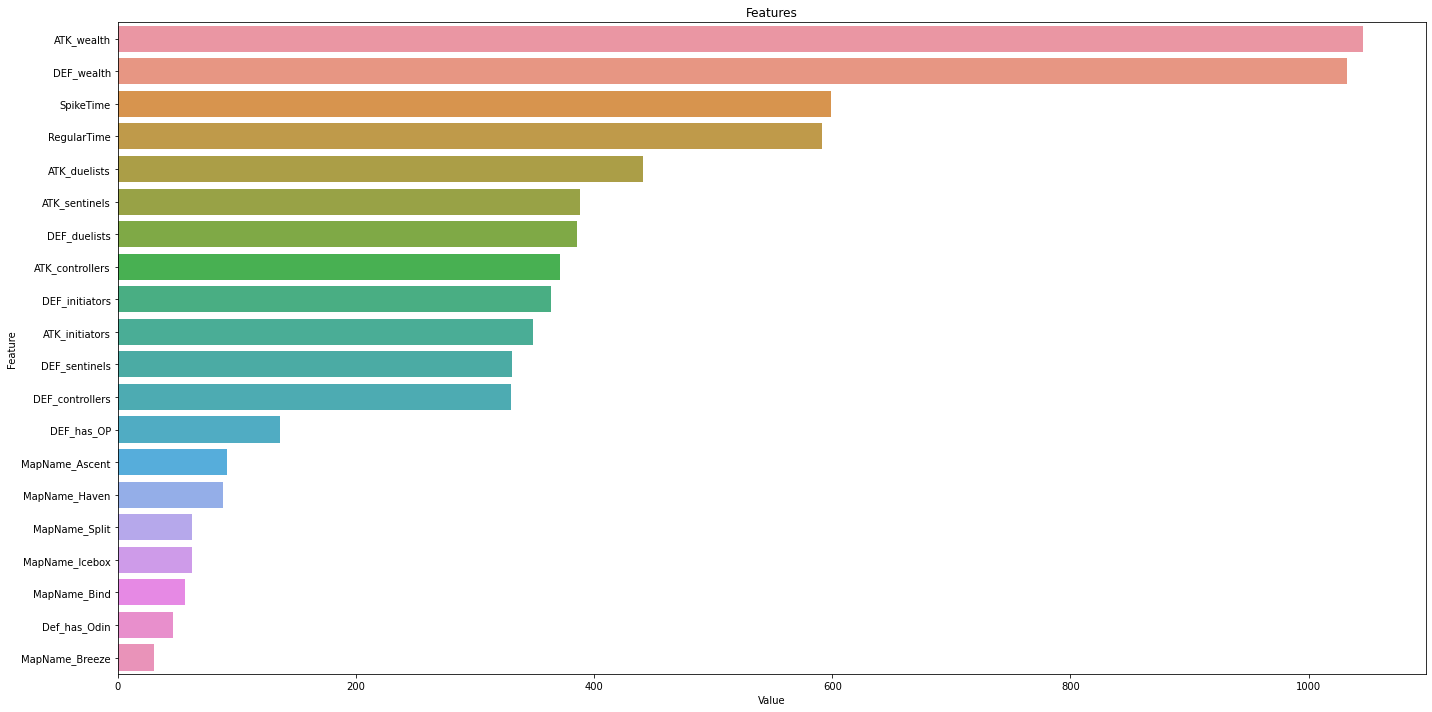

In [13]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

# <font color='blue'>MODEL PRECISION </font>

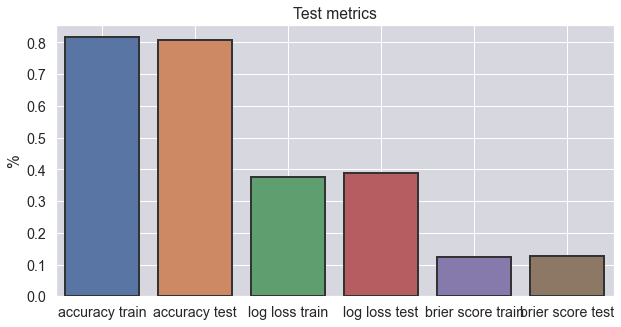

Wall time: 4.79 s


In [14]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [15]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.1279660008947356


# <font color='blue'>REALIBITY CURVE </font>

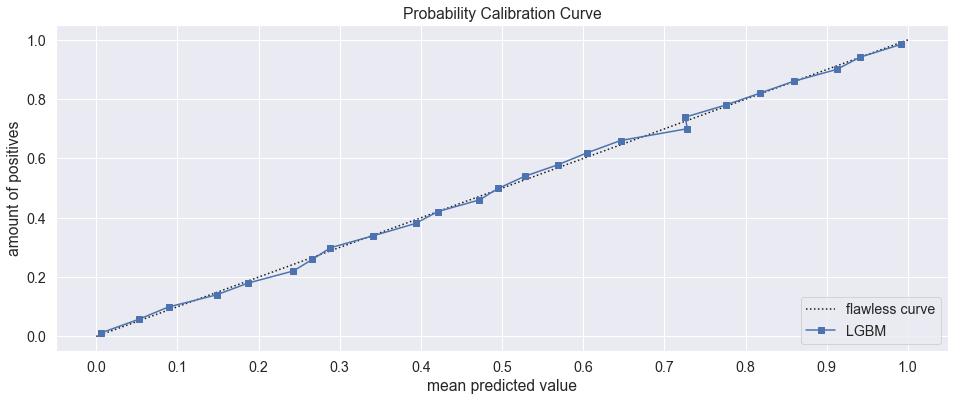

Wall time: 171 ms


Text(0.5, 0, 'mean predicted value')

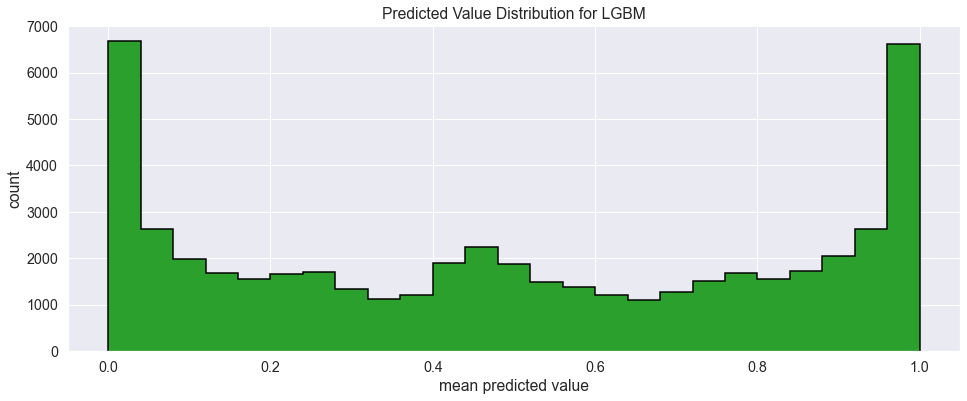

In [16]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

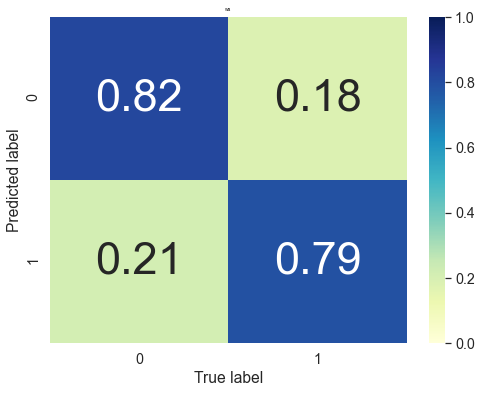

In [17]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [18]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8069097643425968